# 02 Exploratory Data Analysis
**German Energy Demand Patterns**

**Datasets:**
SMARD + DWD TMK + Holidays
- Hourly: [processed/energy_weather_hourly.csv]
- Daily:  [processed/energy_weather_daily.csv]

In [1]:
# Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

# Portfolio Style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
%matplotlib inline

# Load Data
energy_weather_hour = pd.read_csv("../data/processed/energy_weather_hourly.csv")
energy_weather_hour['datetime'] = pd.to_datetime(energy_weather_hour['datetime'])
energy_weather_hour.set_index('datetime', inplace=True)

energy_weather_day = pd.read_csv("../data/processed/energy_weather_daily.csv")
energy_weather_day['date'] = pd.to_datetime(energy_weather_day['date'])
energy_weather_day.set_index('date', inplace=True)

# Restore Weekday Order
energy_weather_hour["weekday"] = pd.Categorical(
    energy_weather_hour["weekday"],
    categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
    ordered=True
)

energy_weather_day["weekday"] = pd.Categorical(
    energy_weather_day["weekday"], 
    categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
    ordered=True
)


## Daily Load Trend (2015-2024)
The Time Series Plot shows a clear downward trend and yearly seasonality.


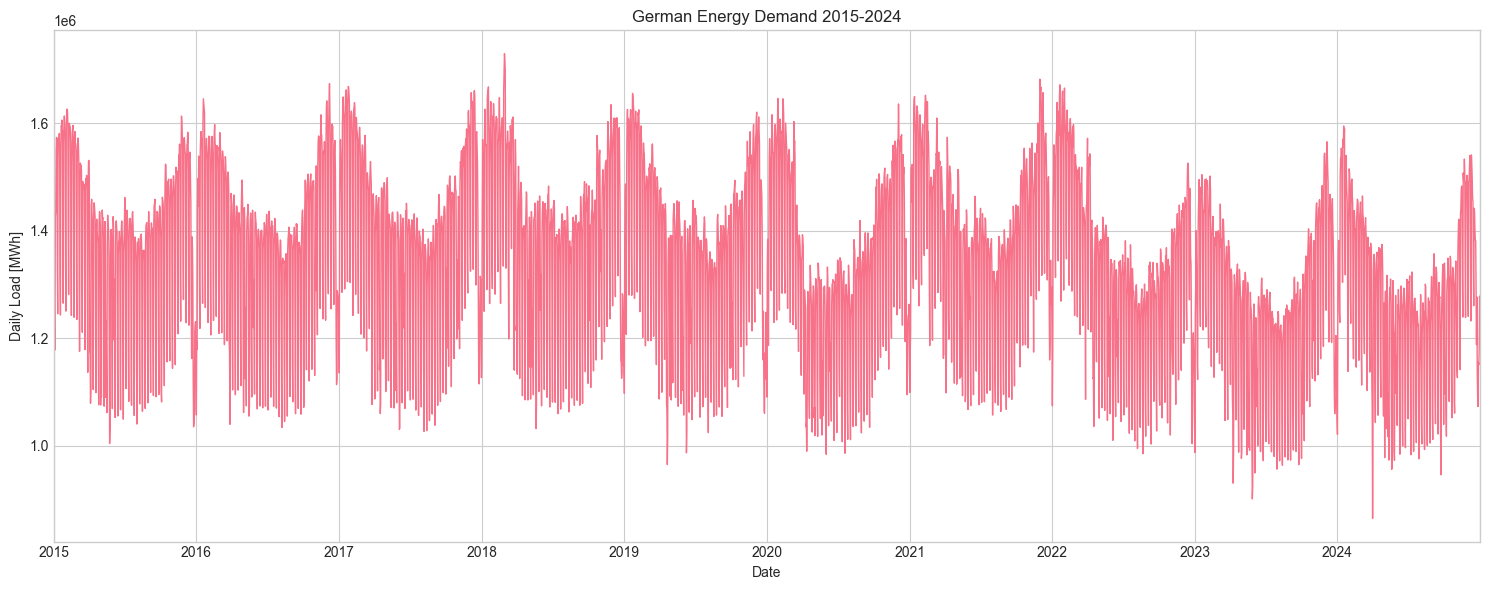

In [2]:
fig, ax = plt.subplots(figsize=(15, 6))
energy_weather_day['load_mwh'].plot(ax=ax, linewidth=1)
ax.set_title('German Energy Demand 2015-2024')
ax.set_ylabel('Daily Load [MWh]')
ax.set_xlabel('Date')
plt.tight_layout()
plt.savefig('../images/01_daily_trend.png', dpi=300, bbox_inches='tight')
plt.show()

## Intraday Pattern (24h x Weekday)
Weekdays follow a similar pattern, with peaks around 11AM and 6PM. Energy Demand drops on weekends.

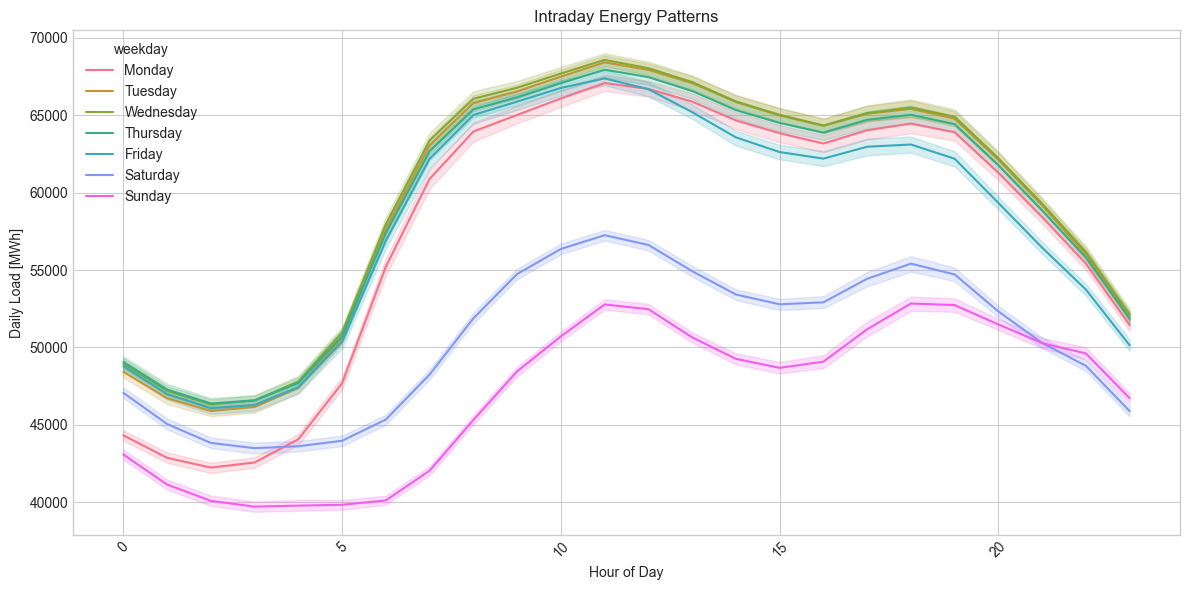

In [3]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=energy_weather_hour, x="hour", y="load_mwh", hue="weekday", ax=ax)
ax.set_title('Intraday Energy Patterns')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Daily Load [MWh]')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../images/02_intraday.png', dpi=300, bbox_inches='tight')
plt.show()

## Autocorrelation
The plot of the autocorrelation function (ACF) examines temporal dependencies in the energy demand data.
- Strong correlations at lag 7 (and its multiples) indicate a clear weekly seasonality.
- The declining autocorrelation for longer lags suggests decreasing dependence across longer time spans.

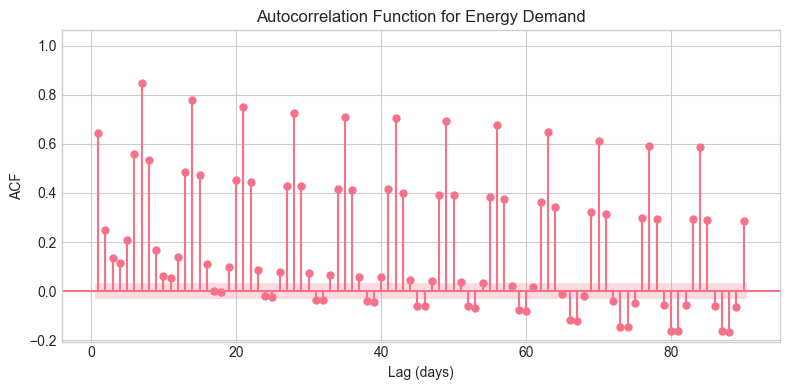

In [8]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_acf(
    energy_weather_day["load_mwh"],
    lags=90,
    ax=ax,
    zero=False,
    bartlett_confint=False,
    auto_ylims=True
)
ax.set_title("Autocorrelation Function for Energy Demand")
ax.set_xlabel("Lag (days)")
ax.set_ylabel("ACF")
plt.tight_layout()
plt.savefig('../images/03_acf_weekly_pattern.png', dpi=300, bbox_inches='tight')
plt.show()

## Seasonal Decomposition

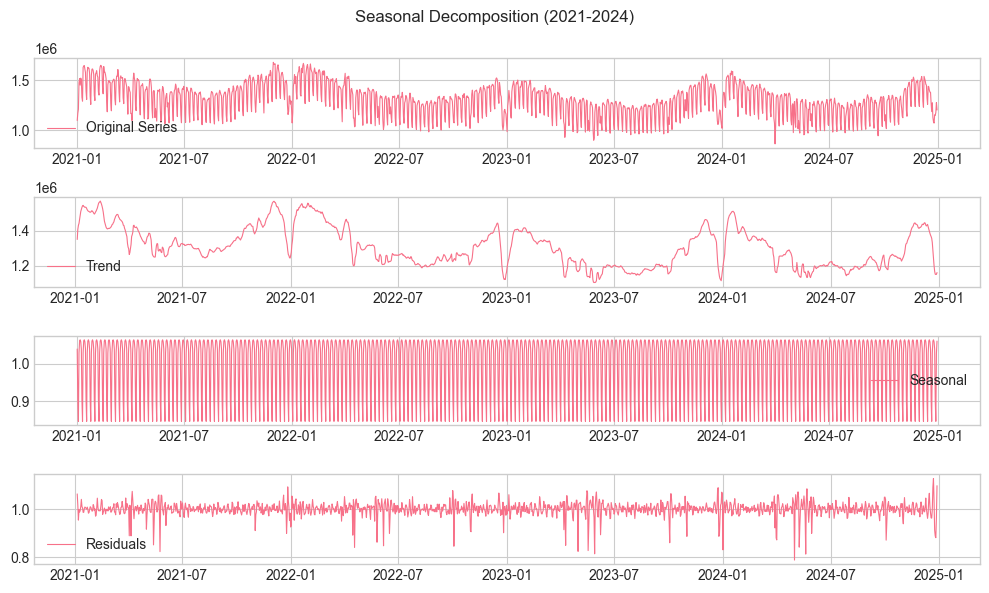

In [4]:
subset = energy_weather_day[energy_weather_day.index.year > 2020].copy()
result = seasonal_decompose(subset['load_mwh'], model='multiplicative', period=7)
trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()

# Plot the decomposed components
plt.figure(figsize=(10,6))

plt.subplot(4, 1, 1)
plt.plot(subset.index, subset['load_mwh'], label='Original Series', linewidth=0.8)
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(subset.index, result.trend, label='Trend', linewidth=0.8)
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(subset.index, result.seasonal, label='Seasonal', linewidth=0.8)
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(subset.index, result.resid, label='Residuals', linewidth=0.8)
plt.legend()

plt.suptitle('Seasonal Decomposition (2021-2024)')
plt.tight_layout()
plt.savefig('../images/04_seasonal_decomposition.png', dpi=300, bbox_inches='tight')
plt.show()

## Weather Correlation
The energy demand vs. temperature scatterplot shows a clear negative correlation (cold → high demand). Holidays are visible as outliers, as they tend to have a unusual low energy demand compared with other weekdays with low temperature.

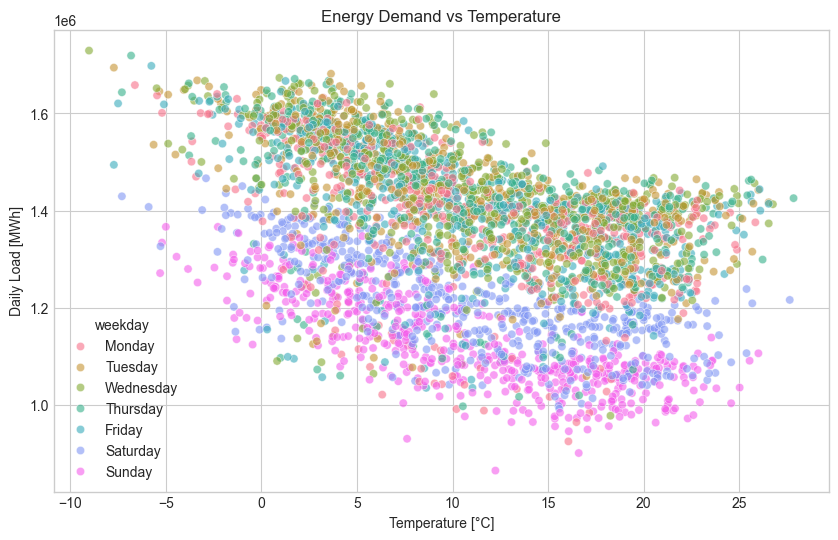

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(data=energy_weather_day, x="TMK", y="load_mwh", 
                hue="weekday", alpha=0.6, ax=ax)
ax.set_title('Energy Demand vs Temperature')
ax.set_ylabel('Daily Load [MWh]')
ax.set_xlabel('Temperature [°C]')
plt.savefig('../images/05_weather.png', dpi=300, bbox_inches='tight')
plt.show()

## Holiday Impact 

**~20% demand drop (1.37M → 1.1M MWh)**

2 "outliers" are Easter/Pentecost Sundays:
- **Only holidays in Brandenburg** (1/16 states) → `is_holiday == 0`
- **IQR per weekday:** Normal within Sunday baseline  
- **Global boxplot:** Bridge day effect visible

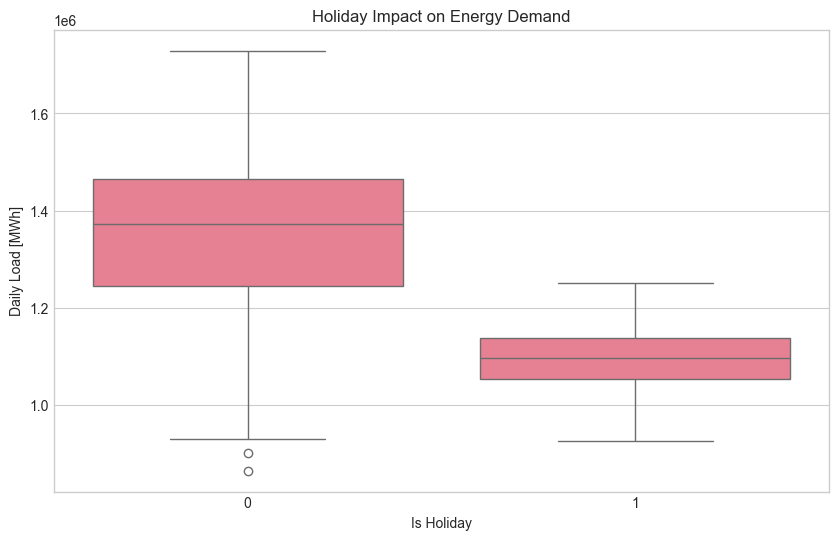

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=energy_weather_day, x="is_holiday", y="load_mwh", ax=ax)
ax.set_title('Holiday Impact on Energy Demand')
ax.set_xlabel('Is Holiday')
ax.set_ylabel('Daily Load [MWh]')
plt.savefig('../images/06_holiday.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
test_df = energy_weather_day[energy_weather_day['is_holiday'] == 0]
q1 = test_df['load_mwh'].quantile(0.25)
q3 = test_df['load_mwh'].quantile(0.75)
iqr = q3 - q1
lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr

test_df[test_df['load_mwh'] < lower]

,load_mwh,weekday,dayofweek,week,month,year,is_holiday,TMK
date,,,,,,,,
2023-05-28,900857.0,Sunday,6,21,5,2023,0,16.60
2024-03-31,864718.0,Sunday,6,13,3,2024,0,12.24
